In [100]:
import glob
%matplotlib inline

import numpy as np  # linear algebra
import os
import nibabel as nib
import ct_utils
import glob

# Some constants
DATA_PATH = '/media/gaetano/DATA/DATA_CT_HEADS/'

In [101]:
data_sample_paths = glob.glob(DATA_PATH + '*')
data_sample_paths.sort()
data_pair_paths = []

def get_sample_pair_paths(sample_path):
    sample_label_paths = glob.glob(sample_path + '/*')
    if len(sample_label_paths) == 1:
        sample_label_paths.append(None)
    else:
        sample_label_paths.reverse()
    return {'data': sample_label_paths[0], 'label': sample_label_paths[1]}

for sample in data_sample_paths:
    data_pair_paths.append(get_sample_pair_paths(sample))

print(len(data_sample_paths))


56


In [102]:
sample = 7
# first_sample = ct_utils.load_scan(paths_to_samples[1])
first_sample = ct_utils.load_scan(data_pair_paths[sample]['data'])
first_sample_pixels = ct_utils.convert_to_hounsfield(first_sample)
nifti = nib.load(data_pair_paths[sample]['label'])
label = np.asarray(nifti.dataobj)
label = label.transpose(2, 1, 0)
print(nifti)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 764)
affine: 
[[   0.4921875    0.           0.        -127.       ]
 [   0.           0.4921875    0.           4.       ]
 [   0.           0.           0.5       -427.1000061]
 [   0.           0.           0.           1.       ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 764   0   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.        0.4921875 0.4921875 0.5       0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration 

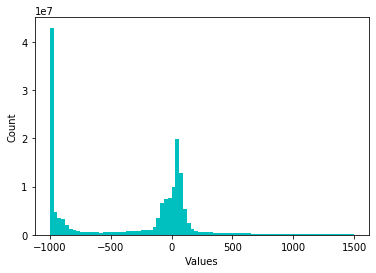

In [103]:
# # Show histogram of Hounsfield density bins
ct_utils.plot_volume_histogram(first_sample_pixels, bins=80, range=(-1000, 1500) ,color='c')

# # Show some slice in the middle
# plt.imshow(first_sample_pixels[80], cmap=plt.cm.gray)
# plt.show()

In [104]:
# Resample volume
spacing = ct_utils.get_dicom_spacing(first_sample)
pix_resampled, _ = ct_utils.resample(first_sample_pixels, spacing)
label_resampled, _ = ct_utils.resample(label, spacing)
print("Data before resampling\t", first_sample_pixels.shape)
print("Label before resampling\t", label.shape)
print("Data after resampling\t", pix_resampled.shape)
print("Label after resampling\t", label_resampled.shape)

Data before resampling	 (764, 512, 512)
Label before resampling	 (764, 512, 512)
Data after resampling	 (382, 252, 252)
Label after resampling	 (382, 252, 252)


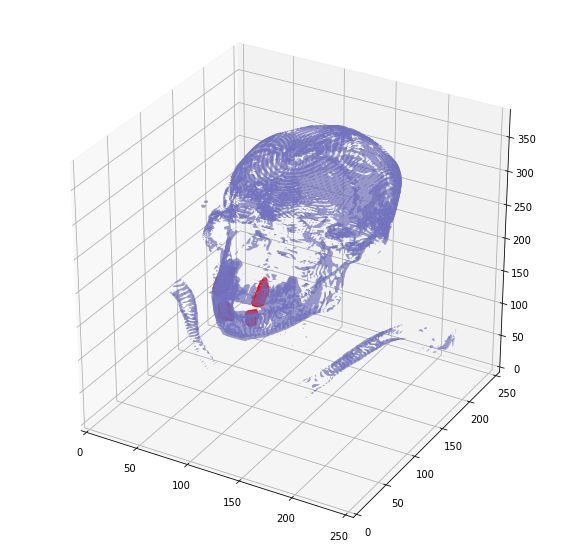

In [105]:
# ct_utils.plot_3d(pix_resampled, 1200, [2, 1, 0], 2)
# ct_utils.plot_3d(label_resampled, 0, [2, 1, 0])
ct_utils.plot_3d_with_labels(pix_resampled, label_resampled, 1200, [2, 1, 0], 2)

In [106]:
# vv = visualize_volumes.ImageSliceViewer3D(pix_resampled)
# ct_utils.make_gifs(pix_resampled, "test_gif", "axial")

![SegmentLocal](test_gif_axial.gif "segment")

In [107]:
min_box, max_box = ct_utils.jaw_isolation(pix_resampled, iterations=4, growth_rate=.98)
jaw_isolated = ct_utils.extract_roi(pix_resampled, min_box, max_box)
label_isolated = ct_utils.extract_roi(label_resampled, min_box, max_box)
print(jaw_isolated.shape)

(75, 61, 74)


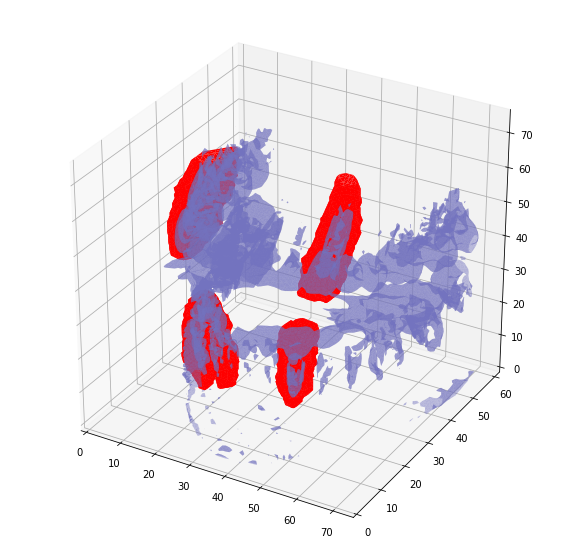

In [108]:
ct_utils.plot_3d_with_labels(jaw_isolated, label_isolated, 1600, [2, 1, 0], 1)

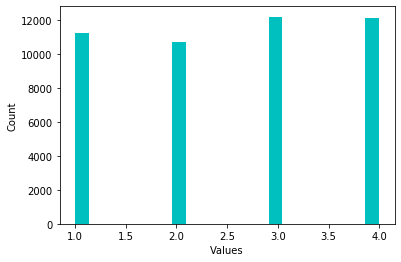

In [109]:
ct_utils.plot_volume_histogram(label, bins=22, range=[1, 4] ,color='c')

In [110]:
# Normalize the image between selected HU units

MIN_BOUND = 1600.0
MAX_BOUND = 1800.0

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [111]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image